# LDA para o Documento de Referência Curricular para Mato Grosso - Educação Infantil e Ensino Fundamental:

## Importação das bibliotecas:

In [2]:
# Para ler o PDF:
import PyPDF2

# Para analisar o layout do PDF e extrair o texto:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

# Para extrair textos de tabelas em PDF:
import pdfplumber

# Para extrair as imagens dos PDFs:
from PIL import Image
from pdf2image import convert_from_path

# Para fazer Reconhecimento Ótico de Caracteres (OCR) para extrair textos das imagens:
import pytesseract

# Para remover os arquivos adicionais criados:
import os

# Para manipulação e análise dos dados:
import pandas as pd
import numpy as np
from collections import Counter

# Para acompanhar a execução dos códigos:
from tqdm import tqdm

# Para análise dos dados textuais:
import re
import nltk
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

# Para visualizações:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# Download do modelo para língua portuguesa:
spacy.cli.download("pt_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [4]:
# Carregamento do modelo:
nlp = spacy.load('pt_core_news_lg')

## 1. Extração das informações do PDF:

In [5]:
# Caminho do arquivo em PDF:
pdf_path = r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Dissertação PROFIAP\LDA\MT\MT_curriculo_EIEF.pdf"

In [5]:
# Função para extração do texto:

def text_extraction(element):
    # Extrair texto:
    line_text = element.get_text()

    # Encontrar o formato do texto:
    # Iniciar a lista com todos os formatos que aparecem nas linhas de texto:
    line_formats = []
    for text_line in element:
        if isinstance(text_line, LTTextContainer):
            # Iterar cada caracter do texto:
            for character in text_line:
                if isinstance(character, LTChar):
                    # Acrescentar o nome da fonte do caracter:
                    line_formats.append(character.fontname)
                    # Acrescentar o tamanho da fonte do caracter:
                    line_formats.append(character.size)
    # Lista de tamanho e nome da fonte dos textos:
    format_per_line = list(set(line_formats))

    # Retornar uma tupla com o texto em cada linha e o seu formato:
    return (line_text, format_per_line)

In [6]:
# Criar uma função que corta as imagens do PDF:
def crop_image(element, pageObj):
    # Conseguir as coordenados para identificar as imagens no PDF:
    [image_left, image_top, image_right, image_bottom] = [element.x0,element.y0,element.x1,element.y1]
    # Cortar a página usando as coordenadas:
    pageObj.mediabox.lower_left = (image_left, image_bottom)
    pageObj.mediabox.upper_right = (image_right, image_top)
    # Salvar a imagem cortada em um novo arquivo PDF:
    cropped_pdf_writer = PyPDF2.PdfWriter()
    cropped_pdf_writer.add_page(pageObj)
    # Salvar o PDF cortado em um novo arquivo:
    with open('cropped_image.pdf', 'wb') as cropped_pdf_file:
        cropped_pdf_writer.write(cropped_pdf_file)

# Criar uma função para converter o PDF em imagens:
def convert_to_images(input_file,):
    images = convert_from_path(input_file, poppler_path=r'D:\Program Files\poppler-23.11.0\Library\bin')
    image = images[0]
    output_file = "PDF_image.png"
    image.save(output_file, "PNG")

# Criar uma função para ler texto das imagens:
def image_to_text(image_path):
    # Ler a imagem:
    img = Image.open(image_path)
    # Extrair o texto da imagem:
    text = pytesseract.image_to_string(img)
    return text

In [7]:
# Extrair tabelas de uma página:

def extract_table(pdf_path, page_num, table_num):
    # Abrir o arquivo em PDF:
    pdf = pdfplumber.open(pdf_path)
    # Encontrar a página:
    table_page = pdf.pages[page_num]
    # Extrair as tabelas:
    table = table_page.extract_tables()[table_num]
    return table

# Converter a tabela em formato apropriado:
def table_converter(table):
    table_string = ''
    # Iterar cada linha da tabela:
    for row_num in range(len(table)):
        row = table[row_num]
        # Remover o separador de linhas de textos quebrados:
        cleaned_row = [item.replace('\n', ' ') if item is not None and '\n' in item else 'None' if item is None else item for item in row]
        # Converter uma tabeça em uma strnig:
        table_string+=('|'+'|'.join(cleaned_row)+'|'+'\n')
    # Remover o último separados de linhas:
    table_string = table_string[:-1]
    return table_string

In [8]:
# Criar um objeto para o arquivo em PDF:
pdfFileObj = open(pdf_path, 'rb')
# Criar um objeto leitor de PDF:
pdfReaded = PyPDF2.PdfReader(pdfFileObj)

# Criar um dicionário para extrair texto de cada imagem:
text_per_page = {}
# Extrair as páginas do PDF:
for pagenum, page in tqdm(enumerate(extract_pages(pdf_path))):

    # Iniciar as variáveis necessárias para extração dos textos de cada página:
    pageObj = pdfReaded.pages[pagenum]
    page_text = []
    line_format = []
    text_from_images = []
    text_from_tables = []
    page_content = []
    # Iniciar o número de tabelas examinadas:
    table_num = 0
    first_element= True
    table_extraction_flag= False
    # Abrir o arquivo em PDF:
    pdf = pdfplumber.open(pdf_path)
    # Encontrar a página examinada:
    page_tables = pdf.pages[pagenum]
    # Encontrar o número de tabelas na página:
    tables = page_tables.find_tables()


    # Encontrar todos os elementos:
    page_elements = [(element.y1, element) for element in page._objs]
    # Classificar os elementos conforme aparecem na página:
    page_elements.sort(key=lambda a: a[0], reverse=True)
    
    lower_side = 0.0
    upper_side = 0.0
    
    # Encontrar os elementos que compõem a página:
    for i,component in enumerate(page_elements):
        # Extrair a posição do elemento:
        pos= component[0]
        # Extrair o elemento do payout da página:
        element = component[1]

        # Checar se o elemento é um texto:
        if isinstance(element, LTTextContainer):
            # Checar se o texto está em uma tabela:
            if table_extraction_flag == False:
                # Extrair o texto e formato de cada elemento textual:
                (line_text, format_per_line) = text_extraction(element)
                # Acrescentar o texto de cada linha:
                page_text.append(line_text)
                # Acrescentar o formato de cada linha contendo texto:
                line_format.append(format_per_line)
                page_content.append(line_text)
            else:
                # Omissão para textos que aparecem em imagens e tabelas:
                pass

        # Checar se o elemento é uma imagem:
        if isinstance(element, LTFigure):
            # Cortar a imagem do arquivo em PDF:
            crop_image(element, pageObj)
            # Converter o PDF cortado em uma imagem:
            convert_to_images('cropped_image.pdf')
            # Extrair o texto da imagem:
            image_text = image_to_text('PDF_image.png')
            text_from_images.append(image_text)
            page_content.append(image_text)
            # Reservar um espaço para lista de textos e formatos:
            page_text.append('image')
            line_format.append('image')

        # Checar os elementos das tabelas:
        if isinstance(element, LTRect):
            # Se o primeiro elementos é retangular:
            if first_element == True and (table_num+1) <= len(tables):
                # Encontrar os limites da tabela:
                lower_side = page.bbox[3] - tables[table_num].bbox[3]
                upper_side = element.y1
                # Extrair as informações da tabela:
                table = extract_table(pdf_path, pagenum, table_num)
                # Converter a informação da tabela em um formato de string:
                table_string = table_converter(table)
                # Adicionar os textos da tabela em uma lista:
                text_from_tables.append(table_string)
                page_content.append(table_string)
                # Definir como 'Verdadeiro' para evitar o conteúdo novamente:
                table_extraction_flag = True
                # Fazer o processo com outro elemento:
                first_element = False
                # Reservar um espaço para lista de textos e formatos:
                page_text.append('table')
                line_format.append('table')

            # Checar se já extraiu as tabelas da página:
            if i + 1 < len(page_elements) and element.y0 >= lower_side and element.y1 <= upper_side:
                pass
            elif i + 1 < len(page_elements) and not isinstance(page_elements[i + 1][1], LTRect):
                table_extraction_flag = False
                first_element = True
                table_num += 1                

    # Criar as páginas como chaves do dicionário:
    dctkey = 'Page_'+str(pagenum)
    # Adicionar as listas como valores para a chave (página do PDF) do dicionário:
    text_per_page[dctkey]= [page_text, line_format, text_from_images,text_from_tables, page_content]
    
# Fechar o objeto do arquivo PDF:
pdfFileObj.close()

# Deletar os arquivos adicionais criados:
os.remove('cropped_image.pdf')
os.remove('PDF_image.png')

684it [08:05,  1.41it/s]


O resultado do processo é armazenado em um dicionário com uma chave para cada página do arquivo PDF e 5 listas para os valores dessa chave. São elas:
[0] 'page_text': contém o texto proveniente dos elementos de texto do PDF;

[1] 'line_format': comtém os formatos dos textos extraídos no elemento acima;

[2] 'text_from_images': comtém os textos extraídos de imagens;

[3] 'text_from_tables': contém os textos das tabelas;

[4] 'page_content': contém todos os textos renderizados na página em uma lista de elementos.

A última lista ('[4] page_content') é o elemento usado para a análise dos textos aqui, pois possui todos os textos extraídos do PDF.

In [12]:
# Criar um DataFrame a partir do dicionário com a 5ª lista ('page_content') do Valor:
df = pd.DataFrame({'Chave': list(text_per_page.keys()),
                   'Valor': [valor[4] for valor in text_per_page.values()]})

# Exibir o DataFrame:
df

,Chave,Valor
0,Page_0,[_\n\nDOCUMENTO DE REFERENCIA CURRICULAR\nPARA...
1,Page_1,"[MINISTÉRIO DA EDUCAÇÃO \n, GOVERNO DO ESTADO ..."
2,Page_2,"[ \n, SUMÁRIO \n, 1. \n, INTRODUÇÃO ............."
3,Page_3,"[ \n, 5. A FORMAÇÃO CONTINUADA DOS PROFISSION..."
4,Page_4,"[ \n, 1. INTRODUÇÃO \n, \n, As Concepções ..."
...,...,...
679,Page_679,"[ \n, - Janet Elizabeth Thomas / Querência - L..."
680,Page_680,"[ \n, Alegre do Norte - Elenir Afonso da Silva..."
681,Page_681,"[ \n, Polo de Juara \nRosalina Ananias Pinheir..."
682,Page_682,"[ \n, da Silva Vieira / Pontes e Lacerda - Day..."


## 2. Pré-processamento dos dados:

### Retirar as páginas que identifiquei que não tem nada de relevante para o conteúdo dos documentos (ex.: sumários, capas, ficha técnica, referências etc):

In [13]:
# Índices das linhas que você deseja excluir
indices_para_excluir = list(range(0, 4)) + list(range(115, 138)) + list(range(138, 142)) + list(range(203, 214)) + list(range(214, 218)) + list(range(344, 355)) + list(range(355, 365)) + list(range(365, 371)) + list(range(426, 430)) + list(range(459, 463)) + list(range(492, 494)) + list(range(533, 536)) + list(range(567, 570)) + list(range(604, 607)) + list(range(628, 631)) + list(range(653, 658)) + list(range(675, 684))

# Usando o método drop para excluir as linhas
df = df.drop(indices_para_excluir)

# Reiniciar os índices se necessário
df = df.reset_index(drop=True)

In [14]:
df

,Chave,Valor
0,Page_4,"[ \n, 1. INTRODUÇÃO \n, \n, As Concepções ..."
1,Page_5,"[ \n, essa explanação, o documento reitera..."
2,Page_6,"[ \n, Da Constituição Federal à BNCC, o avanço..."
3,Page_7,"[ \n, a prática coercitiva de não discrim..."
4,Page_8,"[ \n,  criar e disponibilizar materiais ..."
...,...,...
570,Page_670,"[ \n, pois para o autor, estudantes e professo..."
571,Page_671,"[ \n, |FILOSOFIAS DE VIDA|(EF06ER02) Reconhece..."
572,Page_672,"[ \n, |CRENÇAS RELIGIOSAS E FILOSOFIAS DE VIDA..."
573,Page_673,"[ \n, ||(EF09ER04) Identificar concepções de v..."


In [15]:
# Salvar o DataFrame:
import pickle
df.to_pickle("MT_paginas.pkl")

### Separação e tokenização das frases:

As análises serão feitas separando os textos por frases.

In [16]:
from nltk.tokenize import sent_tokenize

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
# Função para separar as frases de cada página:
def separar_frases(texto):
    return sent_tokenize(texto, language='portuguese')

In [19]:
# Método apply para aplicar a função em cada linha:
df['frases'] = df['Valor'].astype(str).apply(separar_frases)

In [20]:
# Expandir cada frase em uma linha e criar um novo dataframe:
df = pd.DataFrame(df['frases'].explode().reset_index(drop=True))

### Exclusão de sinalização de parágrafos, sinalização de falta de valor e junção de palavras cortadas entre linhas:

In [21]:
# Junção de palavras cortadas entre linhas (possuem '-\n' entre a palavra):

df['frases'] = df['frases'].str.replace(r'-\n', '')

In [22]:
#Exclusão de sinalização de parágrafos (\n):
df['frases'] = df['frases'].str.replace(r'\n', '')

In [23]:
#Exclusão de sinalização de falta de valor ('None'):
df['frases'] = df['frases'].str.replace(r'None', '')

### Pré-processamento:

In [24]:
# Função para pré-processar o texto:
def preprocessar_texto(texto):
    preprocessado = simple_preprocess(texto, deacc=True, min_len=3, max_len=50)
    return preprocessado

In [25]:
# Aplicar a função de pré-processamento para criar a nova coluna:
df['Preprocessado'] = df['frases'].apply(preprocessar_texto)

In [26]:
# Excluir palavras indesejadas:
# "chs" está sendo gerado na identificação das habilidades;

# Função para remover strings específicas das listas:
def remover_string(lista):
    for string_inutil in strings_inuteis:
        if string_inutil in lista:
            lista.remove(string_inutil)
    return lista

strings_inuteis = ["chs"]

In [27]:
# Aplicar a função à coluna do DataFrame
df['Preprocessado'] = df['Preprocessado'].apply(remover_string)

### Remover Stop words:

In [28]:
# Stop words da biblioteca Spacy:
stopwords_spacy = spacy.lang.pt.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(stopwords_spacy))

Number of stop words: 416


In [29]:
# Função para remover as stop words:
def remover_stopwords_spacy(texto):
    return [palavra for palavra in texto if palavra not in stopwords_spacy]

In [30]:
df['Sem_stopwords'] = df['Preprocessado'].apply(remover_stopwords_spacy)

### Stemização:

Há várias opções de stemmers na biblioteca NLTK. Utilizaremos o RSLP que é específico para língua portuguesa.
(https://www.nltk.org/_modules/nltk/stem/rslp.html; https://dfalbel.github.io/rslp/)

In [32]:
from nltk.stem import RSLPStemmer

In [33]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [34]:
def stem_RSLPS(tokens):
    stemmer = RSLPStemmer()
    stem_tokens = [stemmer.stem(token) for token in tokens]
    return stem_tokens

In [35]:
df['Stem'] = df['Sem_stopwords'].apply(stem_RSLPS)

In [36]:
# Salvar o DataFrame:
df.to_pickle("MT_stem.pkl")

## 3. LDA:

In [11]:
# Criar o dicionário de palavras
dicionario = corpora.Dictionary(df['Stem'])

In [12]:
# Criar o corpus
corpus = [dicionario.doc2bow(text) for text in df['Stem']]

### Identificação do melhor valor para Coherence Score:

In [13]:
# Função para testar vários coherence scores e perplexities:

def compute_performance(dictionary, corpus, texts, limit, start, step):
    """
    Computa c_v coherence score para vários números de tópicos.

    Parâmetros:
    dicionário: dicionario;
    corpus: corpus;
    texts: lista de listas com as palavras pré-processadas do documento;
    limit: Máximo nº de tópicos;
    start: Nº de tópicos inicial;
    step: intervalo entre os nº de tópicos testados.

    Resultados:
    model_list: lista de modelos LDA.
    coherence_values: valores de coerência correspondentes ao modelo LDA com o respectivo nº de tópicos.
    """
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dicionario,
                         random_state=42,
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

In [40]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=102,
                                                                           step=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [11:52<00:00, 33.91s/it]


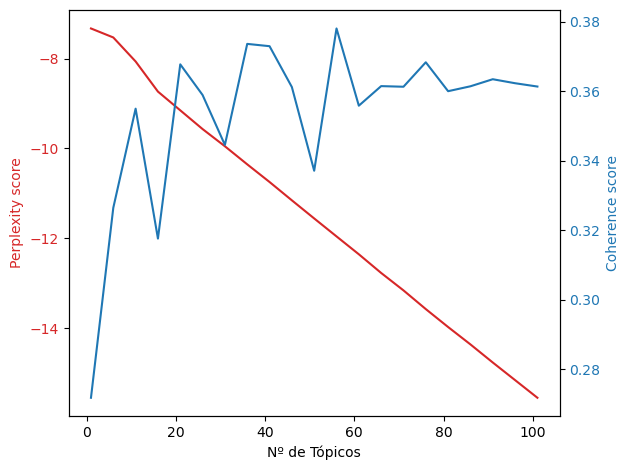

In [41]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=102; start=1; step=5;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('MT_Coherence Score_100 topicos.png')

plt.show()

In [42]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.2718  e valor de perplexidade de -7.3277
A quantidade de tópicos = 6  tem um valor de coerência de  0.3265  e valor de perplexidade de -7.5282
A quantidade de tópicos = 11  tem um valor de coerência de  0.355  e valor de perplexidade de -8.0627
A quantidade de tópicos = 16  tem um valor de coerência de  0.3177  e valor de perplexidade de -8.7338
A quantidade de tópicos = 21  tem um valor de coerência de  0.3678  e valor de perplexidade de -9.1509
A quantidade de tópicos = 26  tem um valor de coerência de  0.359  e valor de perplexidade de -9.5681
A quantidade de tópicos = 31  tem um valor de coerência de  0.3446  e valor de perplexidade de -9.9513
A quantidade de tópicos = 36  tem um valor de coerência de  0.3737  e valor de perplexidade de -10.3537
A quantidade de tópicos = 41  tem um valor de coerência de  0.373  e valor de perplexidade de -10.7469
A quantidade de tópicos = 46  tem um valor de coerência de  0.3613  e valor 

In [14]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=16,
                                                                           limit=26,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:18<00:00, 31.80s/it]


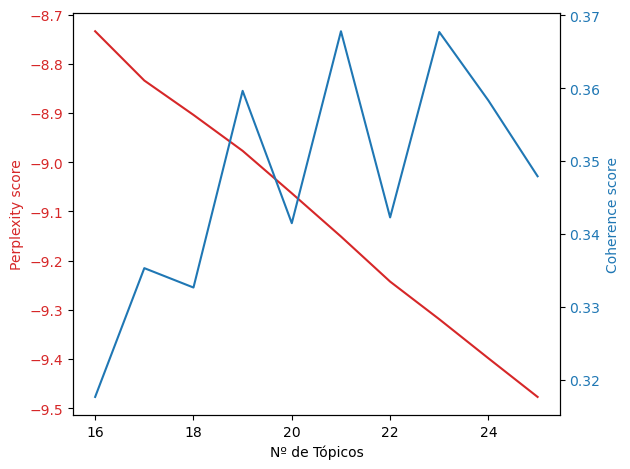

In [15]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=26; start=16; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('MT_Coherence Score_16 - 26 topicos.png')

plt.show()

In [16]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 16  tem um valor de coerência de  0.3177  e valor de perplexidade de -8.7338
A quantidade de tópicos = 17  tem um valor de coerência de  0.3353  e valor de perplexidade de -8.8339
A quantidade de tópicos = 18  tem um valor de coerência de  0.3327  e valor de perplexidade de -8.9037
A quantidade de tópicos = 19  tem um valor de coerência de  0.3596  e valor de perplexidade de -8.9768
A quantidade de tópicos = 20  tem um valor de coerência de  0.3415  e valor de perplexidade de -9.063
A quantidade de tópicos = 21  tem um valor de coerência de  0.3678  e valor de perplexidade de -9.1509
A quantidade de tópicos = 22  tem um valor de coerência de  0.3423  e valor de perplexidade de -9.2425
A quantidade de tópicos = 23  tem um valor de coerência de  0.3677  e valor de perplexidade de -9.3189
A quantidade de tópicos = 24  tem um valor de coerência de  0.3583  e valor de perplexidade de -9.3984
A quantidade de tópicos = 25  tem um valor de coerência de  0.3479  e valo

In [17]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=31,
                                                                           limit=42,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [05:52<00:00, 32.07s/it]


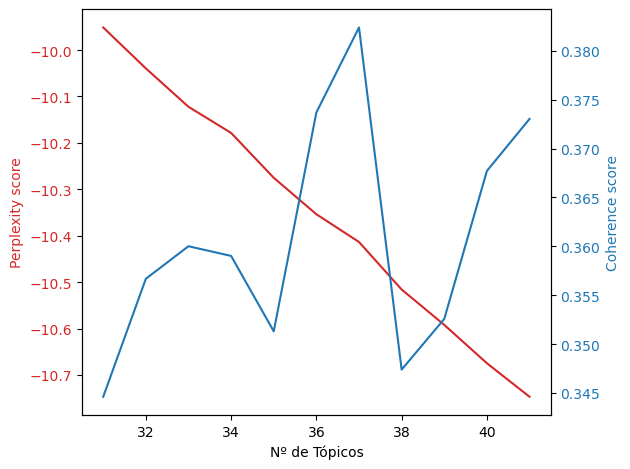

In [18]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
start=31; limit=42; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('MT_Coherence Score_31 - 42 topicos.png')

plt.show()

In [19]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 31  tem um valor de coerência de  0.3446  e valor de perplexidade de -9.9513
A quantidade de tópicos = 32  tem um valor de coerência de  0.3567  e valor de perplexidade de -10.0395
A quantidade de tópicos = 33  tem um valor de coerência de  0.36  e valor de perplexidade de -10.1222
A quantidade de tópicos = 34  tem um valor de coerência de  0.359  e valor de perplexidade de -10.1785
A quantidade de tópicos = 35  tem um valor de coerência de  0.3513  e valor de perplexidade de -10.2752
A quantidade de tópicos = 36  tem um valor de coerência de  0.3737  e valor de perplexidade de -10.3537
A quantidade de tópicos = 37  tem um valor de coerência de  0.3824  e valor de perplexidade de -10.4135
A quantidade de tópicos = 38  tem um valor de coerência de  0.3474  e valor de perplexidade de -10.5159
A quantidade de tópicos = 39  tem um valor de coerência de  0.3526  e valor de perplexidade de -10.5921
A quantidade de tópicos = 40  tem um valor de coerência de  0.3677  

In [20]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=51,
                                                                           limit=61,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:29<00:00, 32.93s/it]


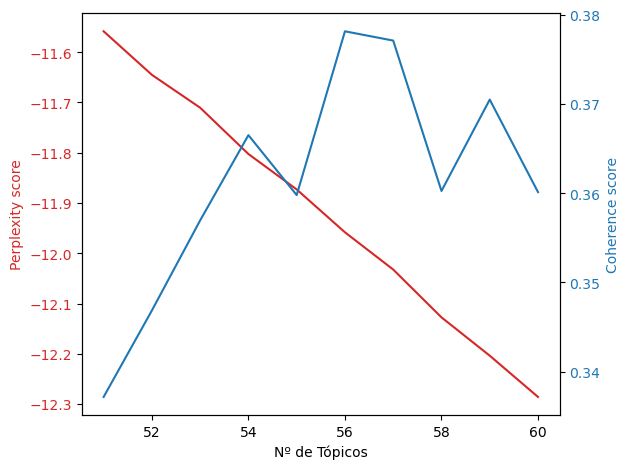

In [21]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
start=51; limit=61; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('MT_Coherence Score_51 - 61 topicos.png')

plt.show()

In [22]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 51  tem um valor de coerência de  0.3372  e valor de perplexidade de -11.5585
A quantidade de tópicos = 52  tem um valor de coerência de  0.3469  e valor de perplexidade de -11.6451
A quantidade de tópicos = 53  tem um valor de coerência de  0.357  e valor de perplexidade de -11.7105
A quantidade de tópicos = 54  tem um valor de coerência de  0.3665  e valor de perplexidade de -11.8026
A quantidade de tópicos = 55  tem um valor de coerência de  0.3598  e valor de perplexidade de -11.8731
A quantidade de tópicos = 56  tem um valor de coerência de  0.3781  e valor de perplexidade de -11.9583
A quantidade de tópicos = 57  tem um valor de coerência de  0.3771  e valor de perplexidade de -12.0324
A quantidade de tópicos = 58  tem um valor de coerência de  0.3602  e valor de perplexidade de -12.1275
A quantidade de tópicos = 59  tem um valor de coerência de  0.3705  e valor de perplexidade de -12.2037
A quantidade de tópicos = 60  tem um valor de coerência de  0.360

In [52]:
# Valor escolhido para coherence score foi 14 tópicos (coherence score = 0.3678):
# Número de tópicos
num_topicos = 21

In [53]:
# Inputar os dados e rodar o modelo LDA:
modelo_lda = LdaModel(corpus=corpus,
                      id2word=dicionario,
                      num_topics=num_topicos,
                      random_state=42,
                      per_word_topics=True)

In [54]:
# Imprimir os tópicos:
for topic_id in range(num_topicos):
    print(f"Topic {topic_id}: {modelo_lda.show_topic(topic_id)}")

Topic 0: [('numer', 0.022196088), ('difer', 0.012093926), ('graf', 0.011449976), ('utiliz', 0.011358713), ('music', 0.010553249), ('uso', 0.009713177), ('adica', 0.00849199), ('objet', 0.008486878), ('verb', 0.008161789), ('discurs', 0.0074559166)]
Topic 1: [('cult', 0.0131132), ('mat', 0.0123856515), ('brasil', 0.011462927), ('gross', 0.011356794), ('educaca', 0.010431102), ('discut', 0.010278539), ('curricul', 0.009539351), ('visual', 0.00942355), ('difer', 0.008365875), ('escol', 0.00769624)]
Topic 2: [('grand', 0.014211246), ('transformaco', 0.013589982), ('estud', 0.013192119), ('camp', 0.012654554), ('circulaca', 0.010291431), ('distribuica', 0.009073859), ('produca', 0.008759037), ('vid', 0.008437683), ('cart', 0.008036155), ('unidad', 0.007710255)]
Topic 3: [('cult', 0.03841766), ('danc', 0.018164627), ('art', 0.015995616), ('difer', 0.015422078), ('brasil', 0.015265694), ('religi', 0.015007631), ('artis', 0.014926687), ('human', 0.013755026), ('mund', 0.013571348), ('corpor', 

### Visualizações:

In [55]:
# Visualização dos tópicos:
visualizacao_BNCC = pyLDAvis.gensim_models.prepare(modelo_lda, corpus, dicionario, n_jobs=1)

In [56]:
# Salvar a visualização como um arquivo HTML:
pyLDAvis.save_html(visualizacao_BNCC, r"MT_visualizacao_BNCC_21_topicos.html")

### Distribuição de palavras por frase:

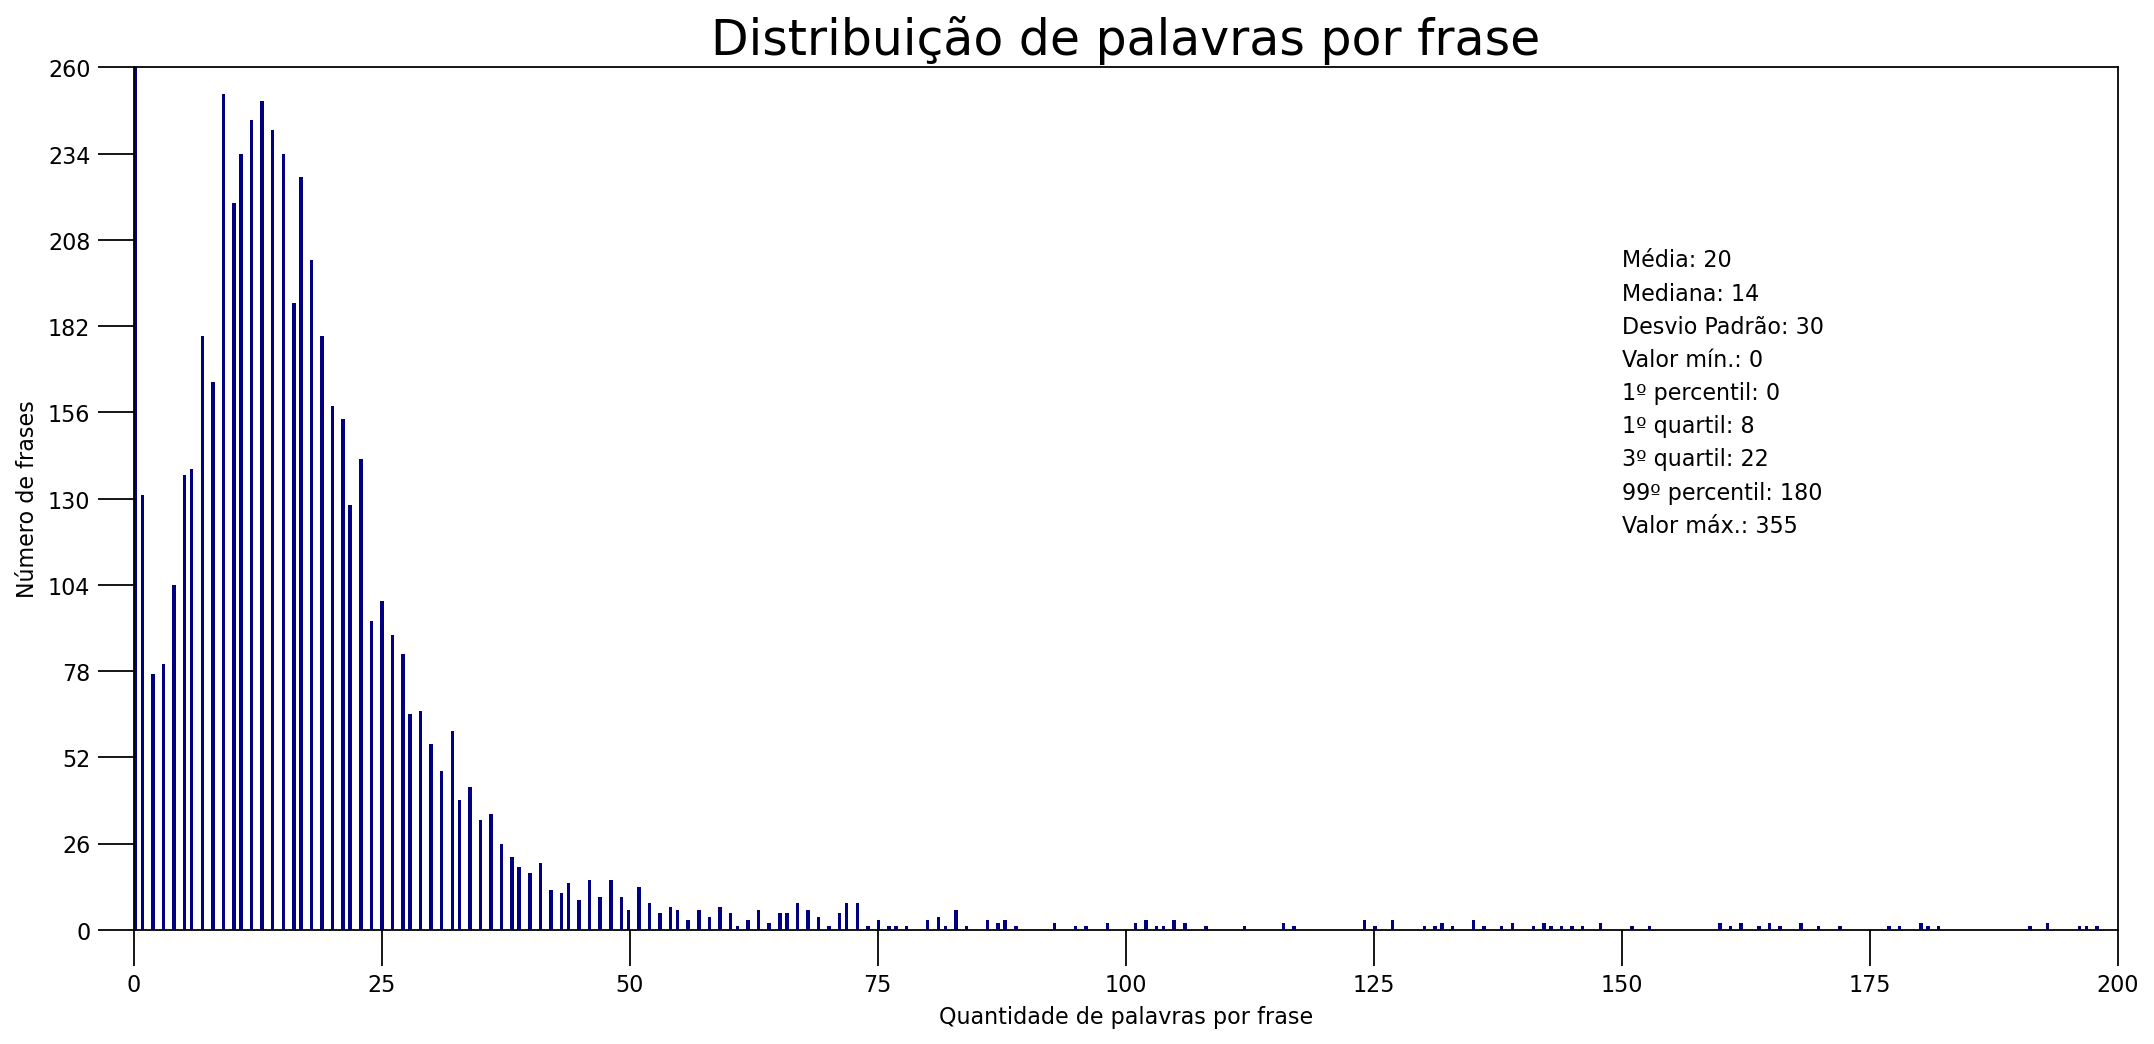

In [60]:
doc_lens = [len(d) for d in df['Stem']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(150, 200, "Média: " + str(round(np.mean(doc_lens))))
plt.text(150, 190, "Mediana: " + str(round(np.median(doc_lens))))
plt.text(150, 180, "Desvio Padrão: " + str(round(np.std(doc_lens))))
plt.text(150, 170, "Valor mín.: " + str(round(np.min(doc_lens))))
plt.text(150, 160, "1º percentil: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(150, 150, "1º quartil: " + str(round(np.quantile(doc_lens, q=0.25))))
plt.text(150, 140, "3º quartil: " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(150, 130, "99º percentil: " + str(round(np.quantile(doc_lens, q=0.99))))
plt.text(150, 120, "Valor máx.: " + str(round(np.max(doc_lens))))

plt.gca().set(xlim=(0, 200), ylim=(0, 260), ylabel='Número de frases', xlabel='Quantidade de palavras por frase')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,200,9))
plt.yticks(np.linspace(0,260,11))
plt.title('Distribuição de palavras por frase', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('MT_Distribuicao_de_palavras_por_frase.png')

plt.show()

### Frequência de palavras em todo o documento:

In [61]:
# Concatenar todas as strings em uma única lista de palavras:
palavras = [palavra for lista in df['Stem'].values for palavra in lista]

# Calcular a frequência das palavras:
freq_dist = FreqDist(palavras)

# Obter as palavras mais frequentes:
top30_palavras = freq_dist.most_common(30)

# Criar um DataFrame com as palavras e suas frequências:
top30_palavras_df = pd.DataFrame(top30_palavras, columns=['Palavra', 'Frequência'])

# Imprimir o DataFrame:
top30_palavras_df

,Palavra,Frequência
0,conhec,1046
1,ensin,999
2,estud,994
3,text,894
4,escol,813
5,educaca,808
6,difer,804
7,cult,761
8,process,738
9,pra,729


"pra" é a raiz de prática.

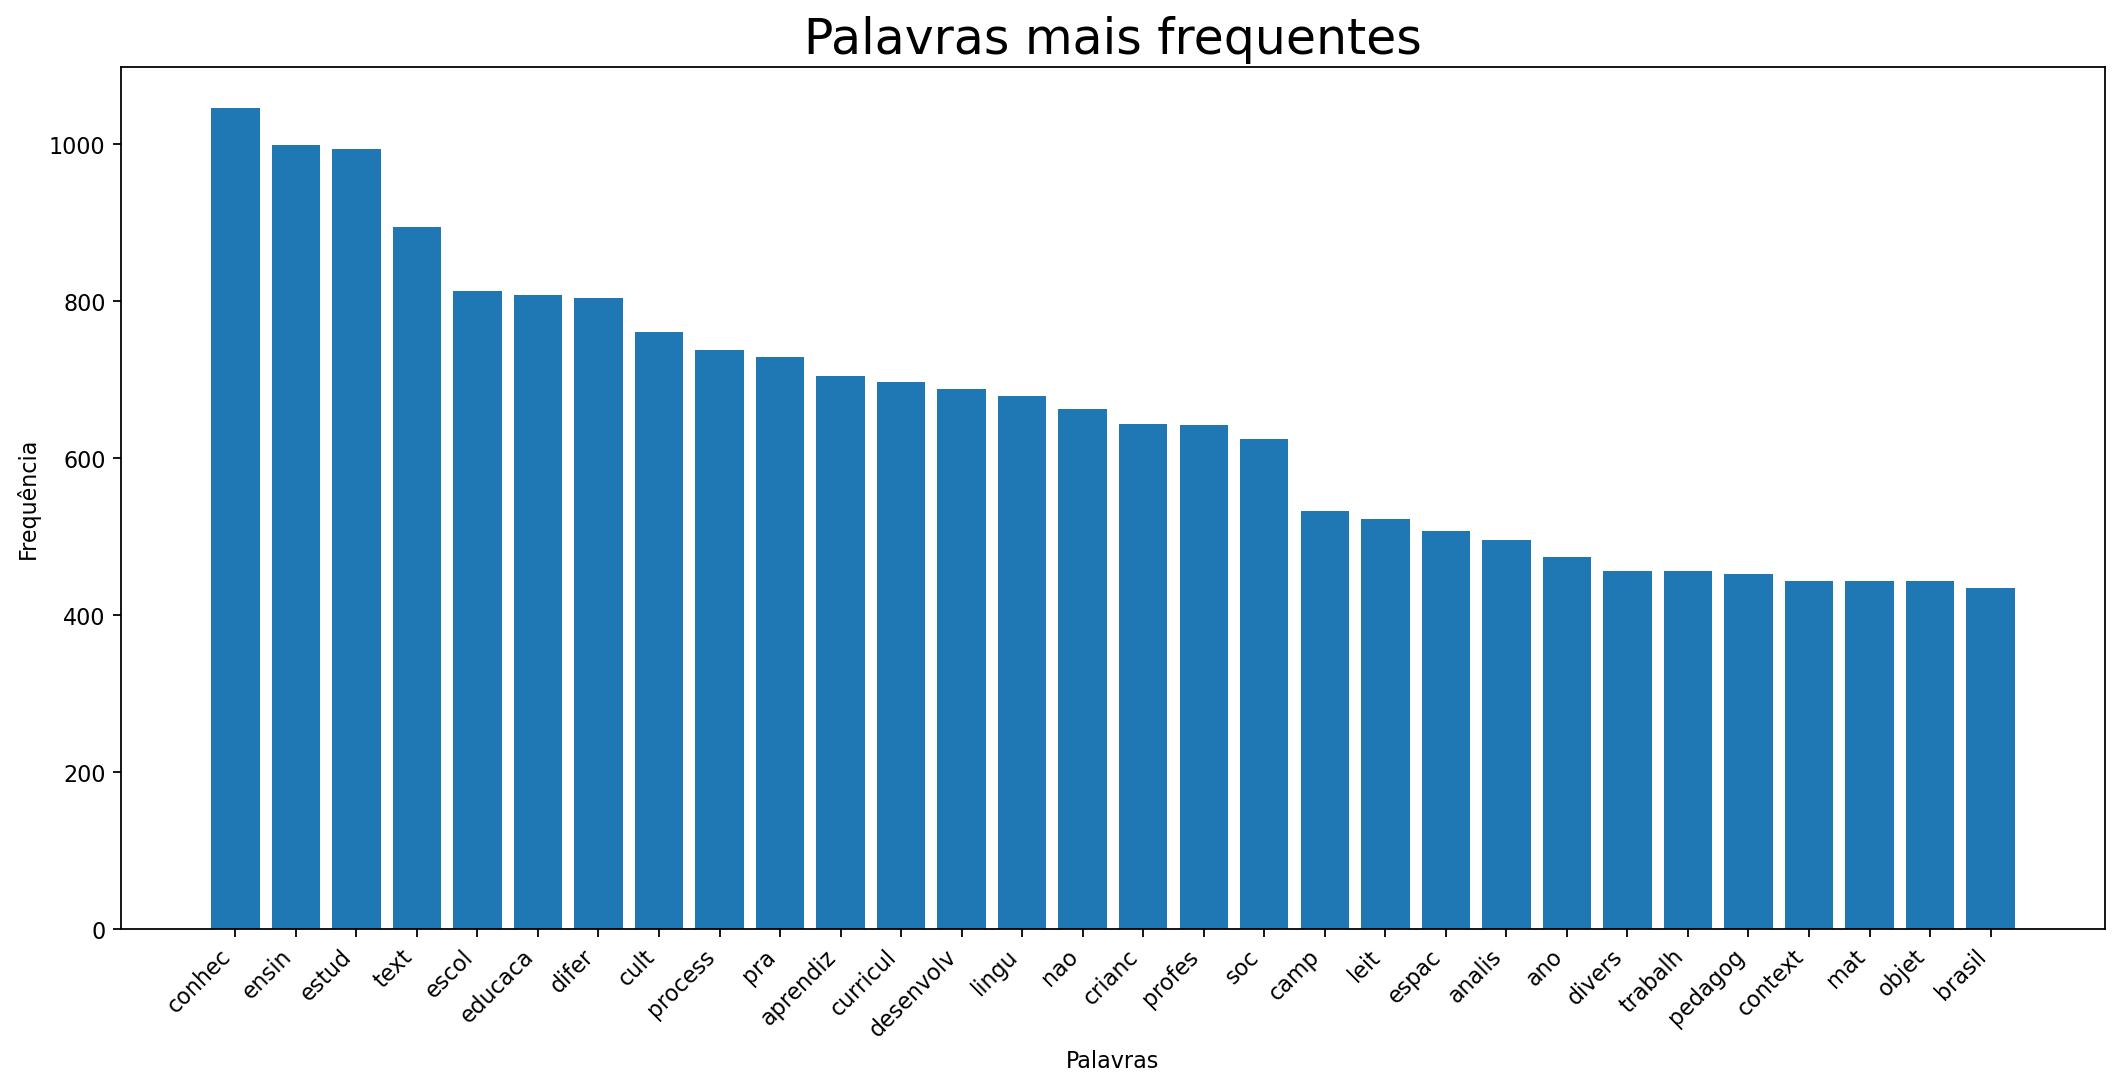

In [62]:
# Criar um gráfico de barras com as palavras mais frequentes:
plt.figure(figsize=(16,7), dpi=160)
plt.bar(top30_palavras_df['Palavra'], top30_palavras_df['Frequência'])
plt.title('Palavras mais frequentes', fontdict=dict(size=22))
plt.xlabel('Palavras')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequência')

# Salvar imagem:
plt.savefig('MT_Palavras mais frequentes.png')

plt.show()

### Nuvem de palavras para todo o documento:

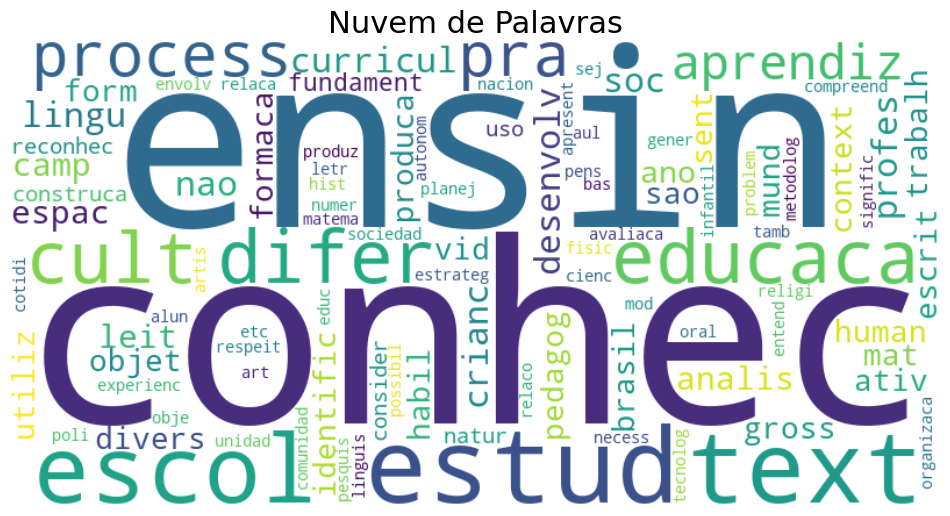

In [63]:
# Criar uma nuvem de palavras:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('MT_Nuvem de palavras_corpus.png')

plt.show()

### Frequência de palavras em cada tópico:

In [65]:
# Criar DataFrame com frequência das palavras no corpus e relevância no tópico:
topics = modelo_lda.show_topics(num_topics=num_topicos, formatted=False)
data_flat = [w for w_list in df['Stem'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_topicos = pd.DataFrame(out, columns=['Stem', 'topic_id', 'relevancia', 'frequencia'])

C:\Users\hugob\AppData\Local\Temp\ipykernel_14100\1779301284.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_14100\1779301284.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_14100\1779301284.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_14100\1779301284.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontal

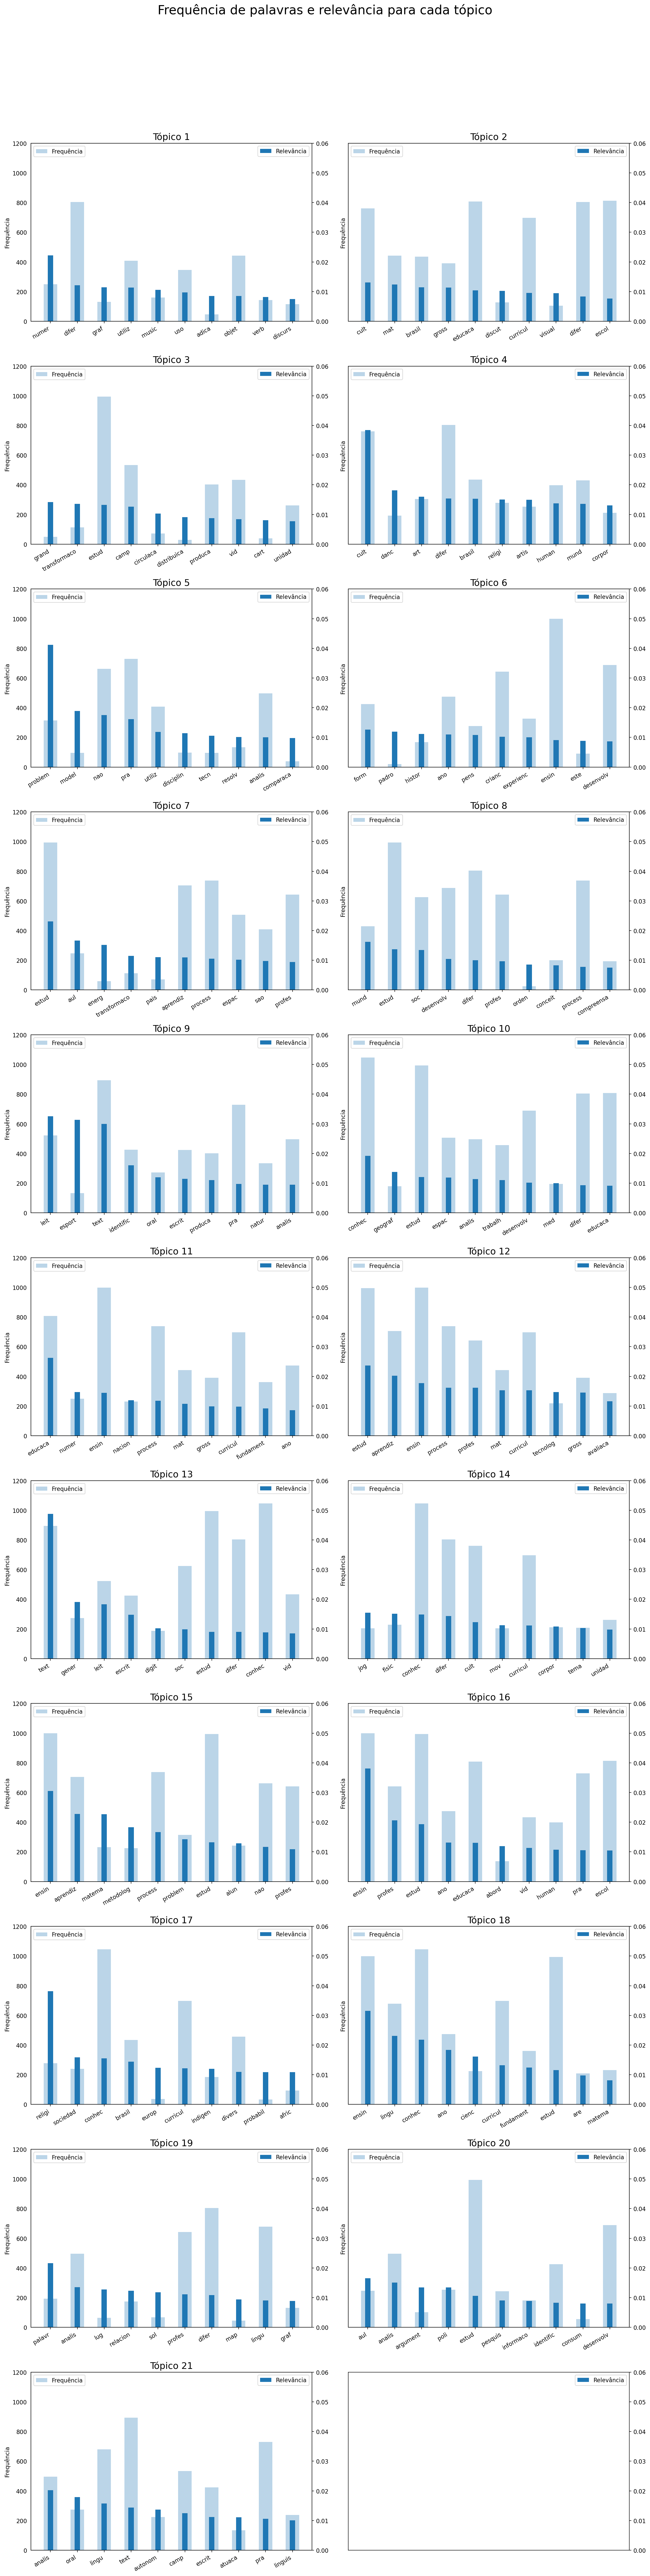

In [67]:
# Plotar contagem de palavras e pesos das palavras mais relevantes:
fig, axes = plt.subplots(11, 2, figsize=(16,60), sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Stem', height="frequencia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.5, alpha=0.3, label='Frequência')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Stem', height="relevancia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.2, label='Relevância')
    ax.set_ylabel('Frequência')
    ax_twin.set_ylim(0, 0.060); ax.set_ylim(0, 1200)
    ax.set_title('Tópico ' + str(i+1), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# Excluir o 22º subplot (na 11ª linha e 2ª coluna):
fig.delaxes(axes[10, 1])
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Frequência de palavras e relevância para cada tópico', fontsize=22, y=1.05)

# Salvar imagem:
plt.savefig('MT_Frequencia e relevancia de palavras por topico.png')

plt.show()

### Nuvem de palavras para cada tópico:

In [8]:
# Configuração do layout dos subplots
num_linhas = 11
num_colunas = 2

# Calcula o número total de subplots necessários
num_subplots = min(num_topicos, num_linhas * num_colunas)

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(30, 80)) 

for topico_id in range(num_subplots):
    # Obter as palavras e frequências associados ao tópico:
    topico_palavras_pesos = modelo_lda.show_topic(topico_id)
    
    # Criar um dicionário de contagem de palavras e pesos:
    contagem_palavras = {palavra: peso for palavra, peso in topico_palavras_pesos}
    
    # Criar o objeto WordCloud:
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(contagem_palavras)
    
    # Adicionar subplot ao layout
    linha = topico_id // num_colunas
    coluna = topico_id % num_colunas
    axs[linha, coluna].imshow(wordcloud, interpolation='bilinear')
    axs[linha, coluna].set_title(f'Tópico {topico_id + 1}', fontdict=dict(size=50))
    axs[linha, coluna].axis('off')

# Colocar o último subplot na última linha entre as duas colunas:
if num_topicos % num_colunas == 1:
    axs[-1, 0].axis('off')  # Desativa os eixos do último subplot na última linha
    axs[-1, 1].remove()     # Remove o último subplot na última linha, segunda coluna
    
# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Salvar imagem:
plt.savefig('MT_Nuvem de palavras por topico.png')

plt.show()